**Import necessary libraries**

In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
from PIL import Image
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import label_binarize

# Import functions from helper.py
from helper import *
from models import MLP_for_DeepFake

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Preprocessing**

In [3]:
# Get transformations
original_transform = get_original_transform()
augmented_transform = get_augmented_transform()

In [4]:
# Load the dataset from the directory
raw_dataset = datasets.ImageFolder(root='../processed_dataset_frame/processed_dataset_frame', transform=None)

# Access a raw image and its label directly
raw_img, label = raw_dataset[0]

# Now apply the transformations to the raw PIL image for demonstration
img_original_tensor = original_transform(raw_img)
img_augmented_tensor = augmented_transform(raw_img)

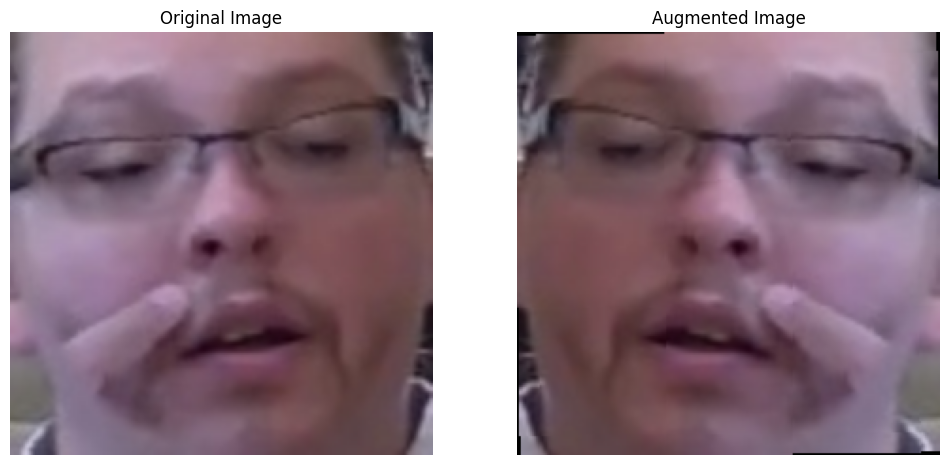

In [5]:
# Access the raw image and its label from dataset
img, label = raw_dataset[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Displaying the original image and the augmented image
show_image(img_original_tensor, title='Original Image', ax=axs[0])
show_image(img_augmented_tensor, title='Augmented Image', ax=axs[1])

plt.show()

In [6]:
# Create the dataloders
root_directory = '../processed_dataset_frame/processed_dataset_frame'
batch_size = 16  # Define the batch size
train_loader, validation_loader, test_loader = setup_data_loaders(root_directory, batch_size)

**Define the MLP Model**

**Initialize MLP Model**

In [7]:
# Model initialization
input_features = 224*224*3  
hidden_units = [512, 256]  
dropout_rate = 0.25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_for_DeepFake(input_features=input_features, dropout_rate=dropout_rate, hidden_units=hidden_units)
model.to(device)

MLP_for_DeepFake(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (act1): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

**Train and evaluate the model (Single trial)**

In [9]:
train_accuracies, test_accuracies, validation_accuracies, train_losses, test_losses, validation_losses = train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10, lr=1e-3)

Epoch 1, Train Loss: 1.3292, Validation Loss: 0.6788, Test Loss: 0.6795, Train Accuracy: 52.84%, Validation Accuracy: 56.32%, Test Accuracy: 57.82%
--------------------------------------------------------------
Epoch 2, Train Loss: 0.6894, Validation Loss: 0.6551, Test Loss: 0.6426, Train Accuracy: 56.26%, Validation Accuracy: 60.66%, Test Accuracy: 63.06%
--------------------------------------------------------------
Epoch 3, Train Loss: 0.6729, Validation Loss: 0.6559, Test Loss: 0.6374, Train Accuracy: 58.71%, Validation Accuracy: 60.73%, Test Accuracy: 61.80%
--------------------------------------------------------------
Epoch 4, Train Loss: 0.6571, Validation Loss: 0.6381, Test Loss: 0.6252, Train Accuracy: 60.34%, Validation Accuracy: 60.10%, Test Accuracy: 62.22%
--------------------------------------------------------------
Epoch 5, Train Loss: 0.6497, Validation Loss: 0.6244, Test Loss: 0.6098, Train Accuracy: 61.86%, Validation Accuracy: 63.10%, Test Accuracy: 65.01%
--------

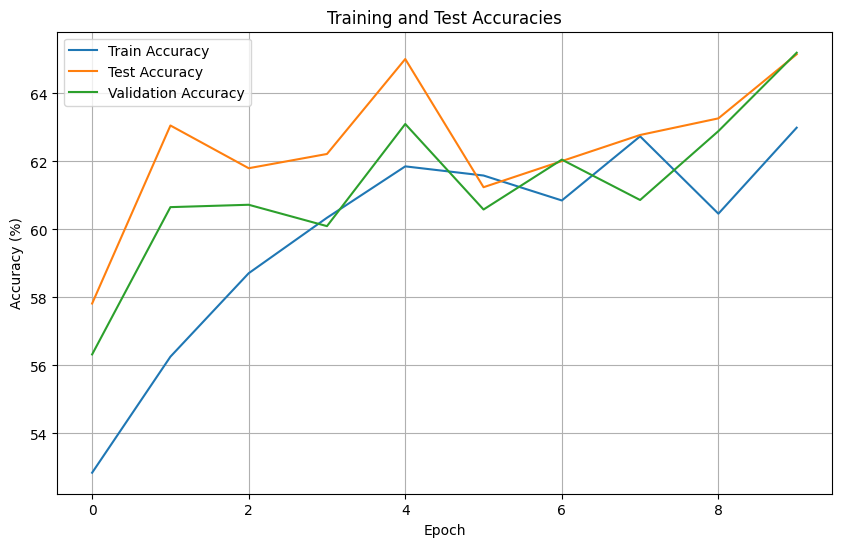

In [10]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()

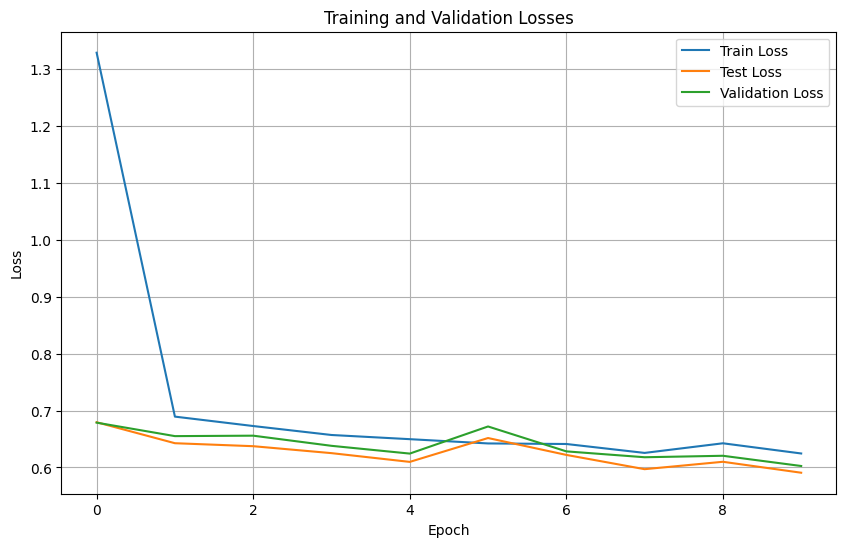

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

**Hyperparameter Search**

In [8]:
hyperparameters = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'dropout_rate': [0.25, 0.5],
    'architecture': [
        [64],  
        [128],  
        [256],  
        [64, 64],  
        [128, 64],  
        [256, 128],  
        [64, 64, 64],  
        [128, 128, 64],  
        [256, 128, 64]  
    ]
}

In [9]:
results, best_model_path = random_search_MLP(hyperparameters, num_trials=10)

Trial 1: Training with lr=0.0001, dropout=0.25, architecture=[256]
Epoch 1, Train Loss: 0.9321, Validation Loss: 0.6863, Test Loss: 0.6482, Train Accuracy: 58.43%, Validation Accuracy: 60.10%, Test Accuracy: 63.20%
--------------------------------------------------------------


KeyboardInterrupt: 

**Visualize the accuracy and loss obtained for all trials**

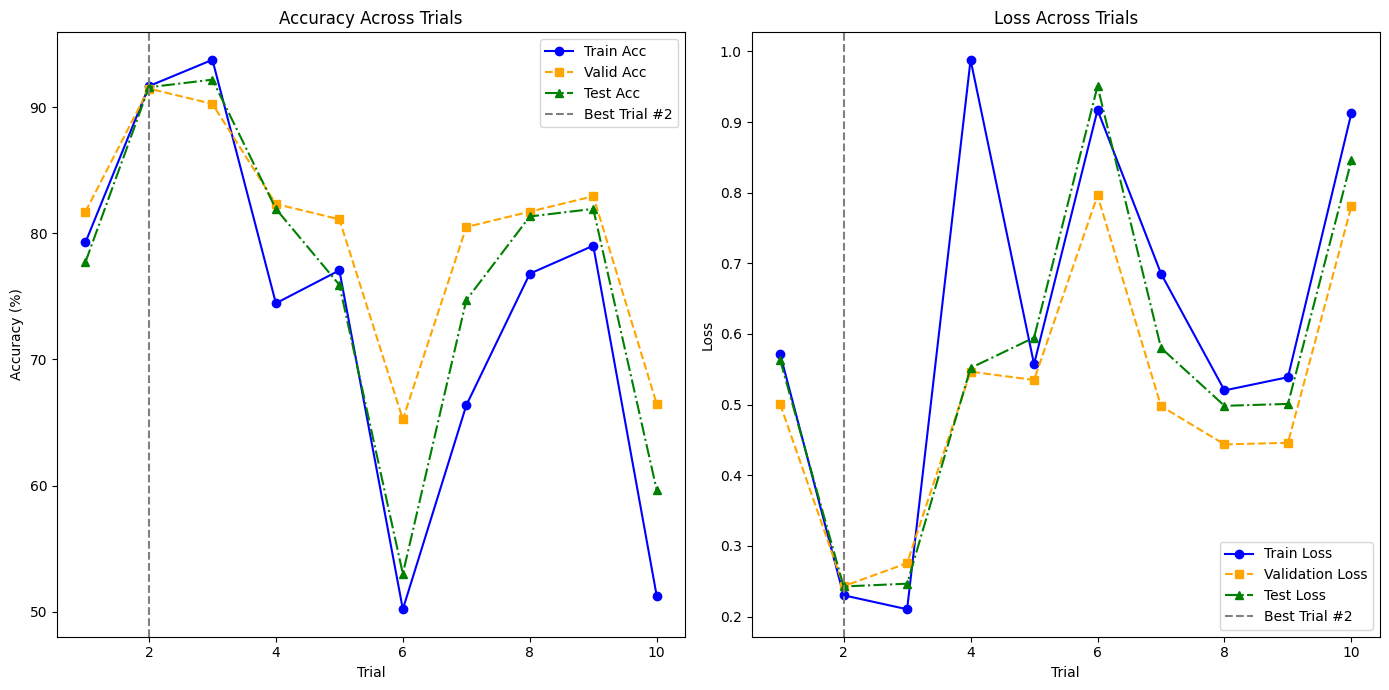

Best Trial: 2 with Validation Accuracy: 91.46341463414635%


In [32]:
train_accuracies = np.array([res['final_train_accuracy'] for res in results])
validation_accuracies = np.array([res['best_validation_accuracy'] for res in results])
test_accuracies = np.array([res['corresponding_test_accuracy'] for res in results])

train_losses = np.array([res['final_train_loss'] for res in results])
validation_losses = np.array([res['best_validation_loss'] for res in results])
test_losses = np.array([res['corresponding_test_loss'] for res in results])

trials = np.arange(1, len(results) + 1)

# Identifying the best trial based on validation accuracy
best_trial_acc = np.argmax(validation_accuracies) + 1
best_acc = validation_accuracies[best_trial_acc - 1]

# Plotting accuracies (training, validation, test)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(trials, train_accuracies, 'o-', label='Train Acc', color='blue')
plt.plot(trials, validation_accuracies, 's--', label='Valid Acc', color='orange')
plt.plot(trials, test_accuracies, '^-.', label='Test Acc', color='green')
plt.axvline(x=best_trial_acc, color='gray', linestyle='--', label=f'Best Trial #{best_trial_acc}')
plt.title('Accuracy Across Trials')
plt.xlabel('Trial')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting losses (training, validation, and test)
plt.subplot(1, 2, 2)
plt.plot(trials, train_losses, 'o-', label='Train Loss', color='blue')
plt.plot(trials, validation_losses, 's--', label='Validation Loss', color='orange')
plt.plot(trials, test_losses, '^-.', label='Test Loss', color='green')
plt.axvline(x=best_trial_acc, color='gray', linestyle='--', label=f'Best Trial #{best_trial_acc}')
plt.title('Loss Across Trials')
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best Trial: {best_trial_acc} with Validation Accuracy: {best_acc}%")